# Projeto 02

**Alunos:**

Lucas Amin

Rafael Toyomoto


In [0]:
# importa os pacotes necessários
import time
import numpy as np
import os, cv2, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 


from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import  cross_val_score

from skimage import exposure
from skimage import feature
from sklearn import svm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.datasets import cifar10

In [2]:
train, test = cifar10.load_data()
print(train[0].shape)

(50000, 32, 32, 3)


### Funções auxiliares

In [0]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def read_image(file_path, rows=32, cols=32, colors=True):
    img =  cv2.imread(file_path, cv2.IMREAD_COLOR if colors else cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (rows, cols), interpolation=cv2.INTER_CUBIC)

def prep_data(images, rows=32, cols=32, colors=True):
    n_imgs = len(images)
    data = []
    
    printProgressBar(0, n_imgs, prefix='Loading images ...:', suffix='Complete', length=50)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file, rows=rows, cols=cols, colors=colors)
        data.append(image)
        if i % 250:
            printProgressBar(i + 1, n_imgs, prefix='Loading images ...:', suffix='Complete', length=50)
    return data

### Descritores ([link](https://scikit-image.org/docs/dev/api/skimage.feature.html))

Foram mantidos os dois descritores disponibilizados, com a acrescimo do descrito utilizando HoG.

In [0]:
# dois exemplos de descritores. Você deve criar outros mais robustos.
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):     
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #image = cv2.imread(image_file)        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

def describe_hog(image):
    hogImage = feature.hog(
        image,
        orientations=9,
        pixels_per_cell=(3, 3),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L1")
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")
    return hogImage.flatten()

In [5]:
train_imgs = train[0]

cifar10_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
labels_onehot = pd.get_dummies(train[1].ravel())
labels_onehot.columns = cifar10_labels

labels_text = [cifar10_labels[i] for i in train[1].ravel()]
print(labels_onehot.columns)
print(labels_text[0:5])
labels_onehot

Index(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
       'ship', 'truck'],
      dtype='object')
['frog', 'truck', 'truck', 'deer', 'automobile']


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
49995,0,0,1,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,1,0,0,0
49997,0,0,0,0,0,0,0,0,0,1
49998,0,1,0,0,0,0,0,0,0,0


In [6]:
rawImages = []
descHist = []
descHOG = []

count = len(train_imgs)

for i, image in enumerate(train_imgs):
    pixels = image_to_feature_vector(image)
    histogram = extract_color_histogram(image)
    hogimg = describe_hog(image)
    
    rawImages.append(pixels)
    descHist.append(histogram)
    descHOG.append(hogimg)
        
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

Processed 0 of 50000
Processed 1000 of 50000
Processed 2000 of 50000
Processed 3000 of 50000
Processed 4000 of 50000
Processed 5000 of 50000
Processed 6000 of 50000
Processed 7000 of 50000
Processed 8000 of 50000
Processed 9000 of 50000
Processed 10000 of 50000
Processed 11000 of 50000
Processed 12000 of 50000
Processed 13000 of 50000
Processed 14000 of 50000
Processed 15000 of 50000
Processed 16000 of 50000
Processed 17000 of 50000
Processed 18000 of 50000
Processed 19000 of 50000
Processed 20000 of 50000
Processed 21000 of 50000
Processed 22000 of 50000
Processed 23000 of 50000
Processed 24000 of 50000
Processed 25000 of 50000
Processed 26000 of 50000
Processed 27000 of 50000
Processed 28000 of 50000
Processed 29000 of 50000
Processed 30000 of 50000
Processed 31000 of 50000
Processed 32000 of 50000
Processed 33000 of 50000
Processed 34000 of 50000
Processed 35000 of 50000
Processed 36000 of 50000
Processed 37000 of 50000
Processed 38000 of 50000
Processed 39000 of 50000
Processed 400

In [0]:
# Preparar os dados a serem utilizados
labels_value = labels_onehot.values
#labels_text = train_data["label"].values

# Criar uma amostra do dataset de treino para teste de desempenho massivos
crop=5000
if 0 < crop < len(rawImages):
    rawImages_redu = rawImages[:crop]
    descHist_redu = descHist[:crop]
    descHOG_redu = descHOG[:crop]
    labels_value_redu = labels_value[:crop]
    labels_text_redu = labels_text[:crop]

In [13]:
labels_onehot.sum(axis=0)

airplane      5000
automobile    5000
bird          5000
cat           5000
deer          5000
dog           5000
frog          5000
horse         5000
ship          5000
truck         5000
dtype: int64

O dataset possui labels equilibrados, não sendo necessário se preocupar com desbalanceamento entre amostras das classes.

# Testes

## Naive Bayes

Vamos utilizar o classificador mais rápido de rodar a fim apenas de confirmar algumas melhorias.

Primeiro vamos aplicar todos descritores puros e após a utilização do PCA.

In [14]:
clf = GaussianNB()
result = {}

for (name, data) in [["RawImg",rawImages],["Hist",descHist],["HoG",descHOG]]:
    #(X_train, X_test, y_train, y_test) = train_test_split(data, labels_text, test_size=0.30, random_state=42)
    
    clf_cv_scores = cross_val_score(clf, data, labels_text, cv=5)
    result[name] = clf_cv_scores
    print(clf_cv_scores)

[0.2889 0.2788 0.2885 0.2783 0.2866]
[0.2151 0.2107 0.2084 0.2097 0.2095]
[0.4302 0.4219 0.4269 0.4238 0.4273]


In [15]:
print(np.mean(result["RawImg"]))
print(np.mean(result["Hist"]))
print(np.mean(result["HoG"]))

0.28422000000000003
0.21067999999999998
0.42602


O descritor HOG apresenta um desempenho muito melhor que os outros, logo será usado para as próximos testes

Vamos agora incluir o uso do PCA nos teste e avaliar seu impacto

In [54]:
from sklearn.decomposition import PCA

for n_components in [8, 64, 128]:
    pca = PCA(n_components=n_components)
    pca_testes = [
        ["RawImg",pca.fit_transform(rawImages)],
        ["Hist",pca.fit_transform(descHist)],
        ["HoG",pca.fit_transform(descHOG)]
    ]

    for (name, data) in pca_testes:
        clf_cv_scores = cross_val_score(clf, data, labels_text, cv=5)
        print(name, np.mean(clf_cv_scores))

RawImg 0.30474
Hist 0.25002
HoG 0.30984
All 0.30846
RawImg 0.35381999999999997
Hist 0.27472
HoG 0.38178
All 0.3829
RawImg 0.3269
Hist 0.25595999999999997
HoG 0.36906
All 0.37032


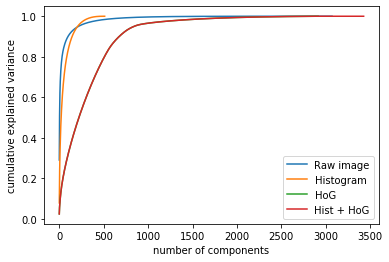

In [55]:
plt.plot(np.cumsum(PCA().fit(rawImages).explained_variance_ratio_), label="Raw image")
plt.plot(np.cumsum(PCA().fit(descHist).explained_variance_ratio_), label="Histogram")
plt.plot(np.cumsum(PCA().fit(descHOG).explained_variance_ratio_), label="HoG")
plt.plot(np.cumsum(PCA().fit(np.hstack((descHist, descHOG))).explained_variance_ratio_), label="Hist + HoG")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend()

Usar o PCA piorou os resultados sem dar uma real melhoria de velocidade.

## Teste com outros classificadores

In [0]:
#pca = PCA(n_components=64)
#pca_descriptor = pca.fit_transform(np.hstack((descHist, descHOG)))
(X_train, X_test, y_train, y_test) = train_test_split(descHOG, labels_text, test_size=0.10, random_state=42)

KNeighborsClassifier


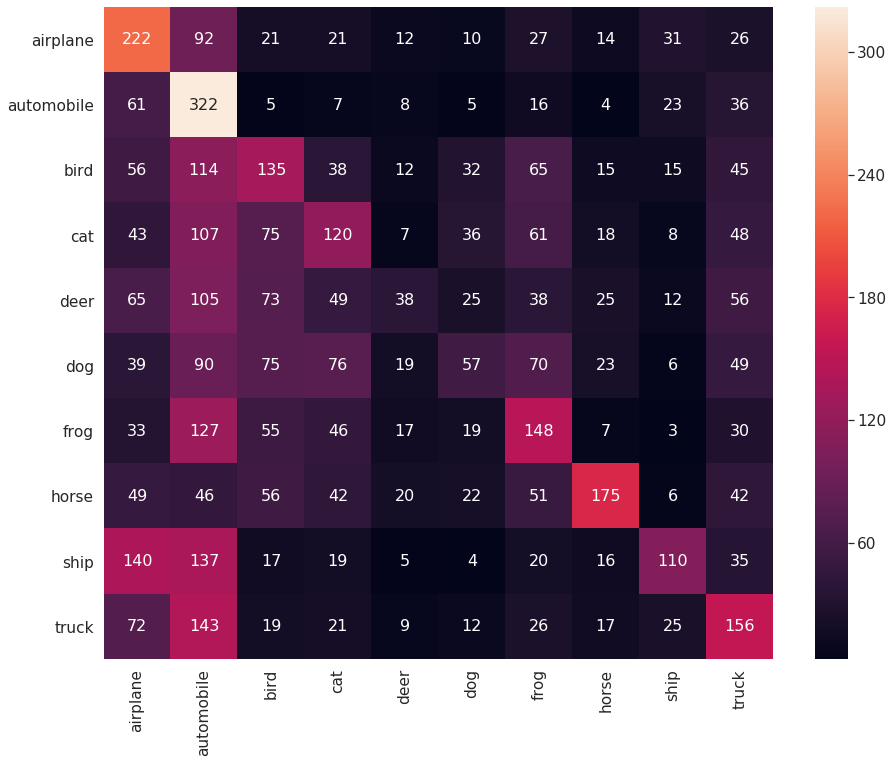

              precision    recall  f1-score   support

    airplane       0.28      0.47      0.35       476
  automobile       0.25      0.66      0.36       487
        bird       0.25      0.26      0.26       527
         cat       0.27      0.23      0.25       523
        deer       0.26      0.08      0.12       486
         dog       0.26      0.11      0.16       504
        frog       0.28      0.31      0.29       485
       horse       0.56      0.34      0.43       509
        ship       0.46      0.22      0.30       503
       truck       0.30      0.31      0.30       500

    accuracy                           0.30      5000
   macro avg       0.32      0.30      0.28      5000
weighted avg       0.32      0.30      0.28      5000

accuracy: 29.66%
DecisionTreeClassifier


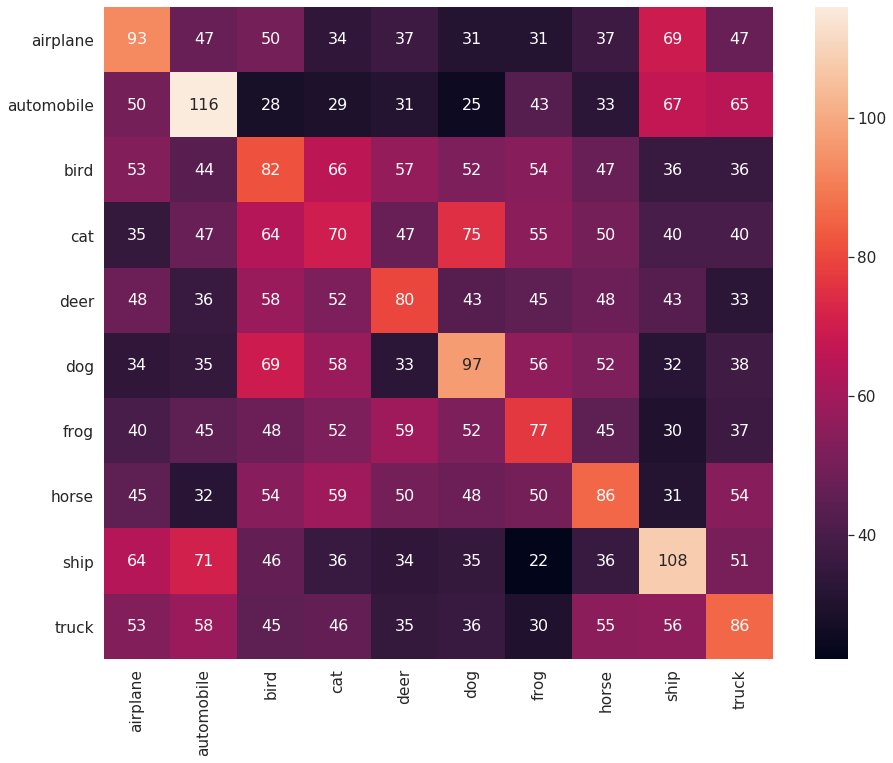

              precision    recall  f1-score   support

    airplane       0.18      0.20      0.19       476
  automobile       0.22      0.24      0.23       487
        bird       0.15      0.16      0.15       527
         cat       0.14      0.13      0.14       523
        deer       0.17      0.16      0.17       486
         dog       0.20      0.19      0.19       504
        frog       0.17      0.16      0.16       485
       horse       0.18      0.17      0.17       509
        ship       0.21      0.21      0.21       503
       truck       0.18      0.17      0.17       500

    accuracy                           0.18      5000
   macro avg       0.18      0.18      0.18      5000
weighted avg       0.18      0.18      0.18      5000

accuracy: 17.90%
GaussianNB


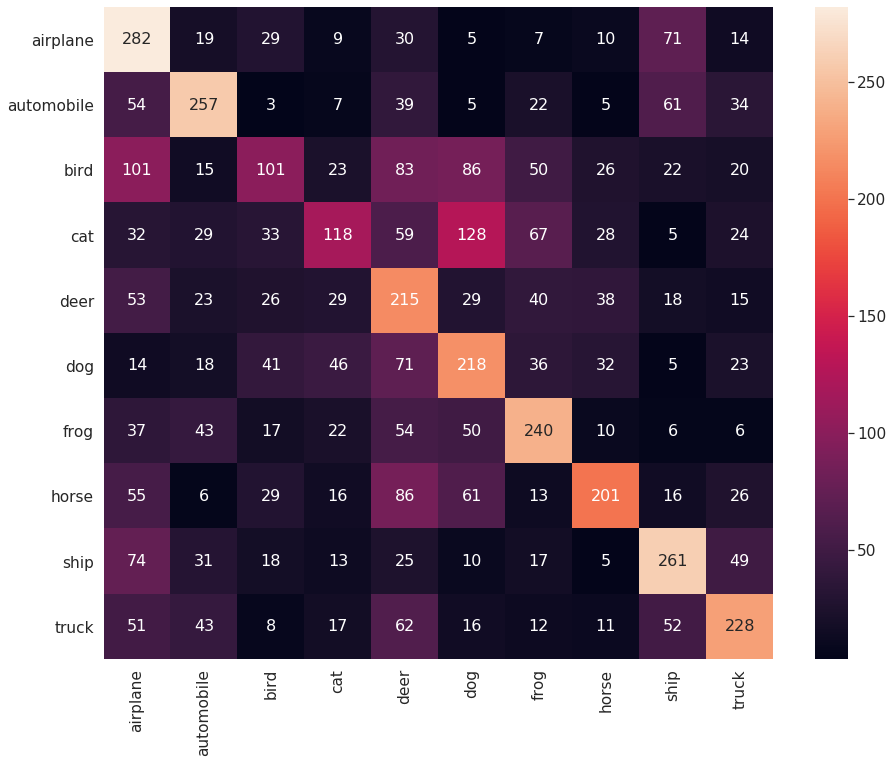

              precision    recall  f1-score   support

    airplane       0.37      0.59      0.46       476
  automobile       0.53      0.53      0.53       487
        bird       0.33      0.19      0.24       527
         cat       0.39      0.23      0.29       523
        deer       0.30      0.44      0.36       486
         dog       0.36      0.43      0.39       504
        frog       0.48      0.49      0.49       485
       horse       0.55      0.39      0.46       509
        ship       0.50      0.52      0.51       503
       truck       0.52      0.46      0.49       500

    accuracy                           0.42      5000
   macro avg       0.43      0.43      0.42      5000
weighted avg       0.43      0.42      0.42      5000

accuracy: 42.42%


In [35]:
classifiers = [
    KNeighborsClassifier(3),    
    DecisionTreeClassifier(),
    GaussianNB()]

for clf in classifiers:
    print("="*30)
    print(clf.__class__.__name__)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=None)

    df_cm = pd.DataFrame(cm, range(10), range(10))

    plt.figure(figsize=(15,12))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g', xticklabels=cifar10_labels, yticklabels=cifar10_labels)# font size
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

    print(classification_report(y_test, y_pred))
    
    acc = accuracy_score(y_test, y_pred)
    print("accuracy: {:.2f}%".format(acc * 100))


## SVM ([referência](https://scikit-learn.org/stable/modules/svm.html))

Foram realizados alguns testes utilizando SVM a fim de avaliar seu desempenho.

In [43]:
(X_train, X_test, y_train, y_test) = train_test_split(descHOG, labels_text, test_size=0.10, random_state=42)

clf = svm.LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)

print("Result:")

train_predictions = clf.predict(X_test)

acc = accuracy_score(y_test, train_predictions)

print("accuracy: {:.2f}%".format(acc * 100))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Result:
accuracy: 36.76%


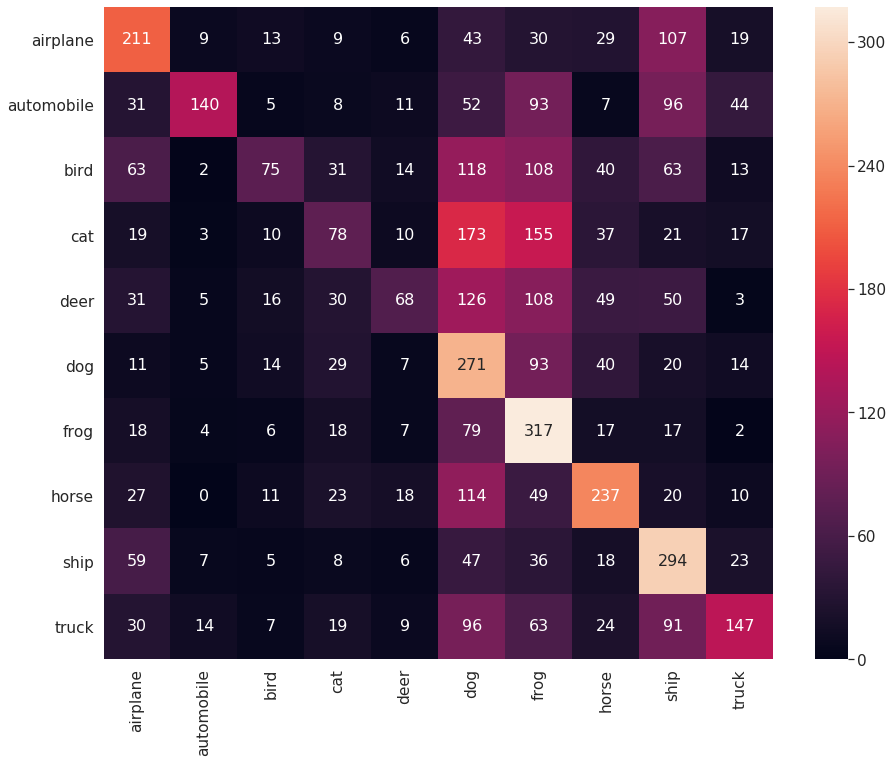

              precision    recall  f1-score   support

    airplane       0.42      0.44      0.43       476
  automobile       0.74      0.29      0.41       487
        bird       0.46      0.14      0.22       527
         cat       0.31      0.15      0.20       523
        deer       0.44      0.14      0.21       486
         dog       0.24      0.54      0.33       504
        frog       0.30      0.65      0.41       485
       horse       0.48      0.47      0.47       509
        ship       0.38      0.58      0.46       503
       truck       0.50      0.29      0.37       500

    accuracy                           0.37      5000
   macro avg       0.43      0.37      0.35      5000
weighted avg       0.43      0.37      0.35      5000



In [44]:
cm = confusion_matrix(y_test, train_predictions, labels=None)

df_cm = pd.DataFrame(cm, range(10), range(10))

plt.figure(figsize=(15,12))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g', xticklabels=cifar10_labels, yticklabels=cifar10_labels)# font size
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

print(classification_report(y_test, train_predictions))

# Conclusão

O melhor classificador treinado foi o Naive Bayes, treinado usando o descritor HOG, tendo o melhor desempenho e mais curto tempo de predição.

O SVM treinado se mostrou promissor nos resultados, entretanto não foi treinado e ajustado por tempo o bastante para apresentar um resultado melhor do que o obtido com Naive Bayes.